In [1]:
import pandas as pd
import numpy as np
import time
import datetime
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn import metrics                       

In [3]:
IBM_final = pd.read_csv("/Users/macbook/Downloads/IBM.csv")

In [4]:
IBM_final.set_index('Date', inplace = True)

In [5]:
IBM_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5531 entries, 2000-02-22 00:00:00 to 2022-02-11 00:00:00
Data columns (total 50 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 5531 non-null   int64  
 1   AdjClose                   5531 non-null   float64
 2   Open                       5531 non-null   float64
 3   High                       5531 non-null   float64
 4   Low                        5531 non-null   float64
 5   Close                      5531 non-null   float64
 6   Volume                     5531 non-null   int64  
 7   avg7                       5531 non-null   float64
 8   avg10                      5531 non-null   float64
 9   avg50                      5531 non-null   float64
 10  avg100                     5531 non-null   float64
 11  avg200                     5531 non-null   float64
 12  avg253                     5531 non-null   float64
 13  SPD_OPEN/CLOSE      

In [6]:
train_pct_index = int(0.7*len(IBM_final))
train, test = IBM_final[:train_pct_index],IBM_final[train_pct_index:]

In [7]:
lags = 2
def create_lags(data):
  global cols
  cols = []
  for lag in range(1, lags + 1):
    col = 'lag_{}'.format(lag)
    data[col] = data['Log_Returns'].shift(lag)
    cols.append(col)

In [8]:
create_lags(train)
create_lags(test)

/var/folders/lc/hpq1rlgx6p1fkn9fvvqk3p880000gn/T/ipykernel_16537/1615434950.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data['Log_Returns'].shift(lag)


In [9]:
train = train.fillna(0)
test = test.fillna(0)

In [10]:
model = KMeans(n_clusters=2, random_state=0) 
model.fit(train[cols])
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
n_clusters=2, n_init=10,
random_state=0, tol=0.0001, verbose=0)

KMeans(n_clusters=2, random_state=0)

In [11]:
train['pos_clus'] = model.predict(train[cols])
test['pos_clus'] = model.predict(test[cols])
train['pos_clus'] = np.where(train['pos_clus'] == 1, -1, 1) 
test['pos_clus'] = np.where(test['pos_clus'] == 1, -1, 1) 

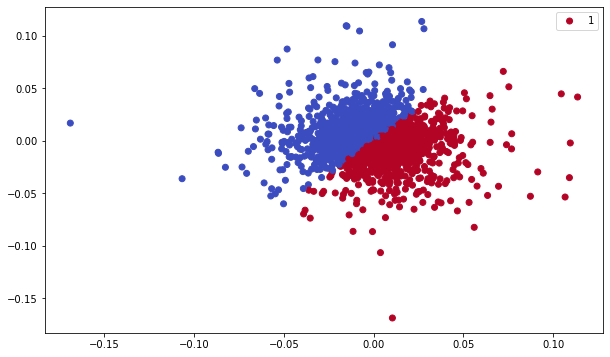

In [12]:
plt.figure(figsize=(10, 6))
plt.scatter(train[cols].iloc[:, 0], train[cols].iloc[:, 1],
c=train['pos_clus'], cmap='coolwarm', label = train['pos_clus'])
plt.legend(train['pos_clus'])
plt.show()

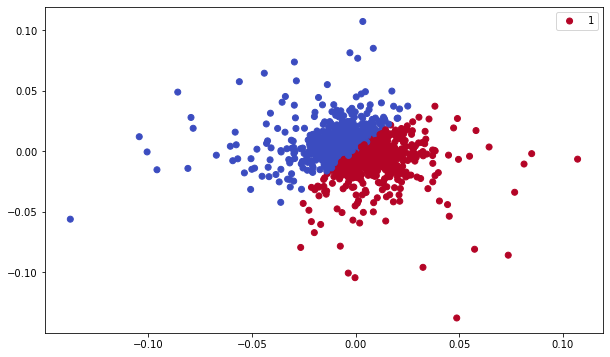

In [13]:
plt.figure(figsize=(10, 6))
plt.scatter(test[cols].iloc[:, 0], test[cols].iloc[:, 1],
c=test['pos_clus'], cmap='coolwarm', label = test['pos_clus'])
plt.legend(test['pos_clus'])
plt.show()

In [14]:
train['strat_clus'] = train['pos_clus'] * train['Log_Returns']

In [15]:
test['strat_clus'] = test['pos_clus'] * test['Log_Returns']

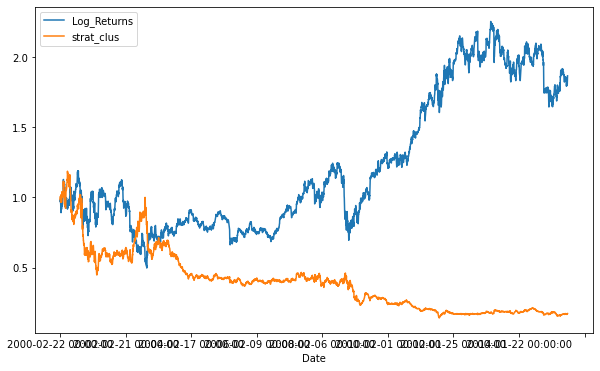

In [16]:
train[['Log_Returns', 'strat_clus']].cumsum(
).apply(np.exp).plot(figsize=(10, 6));

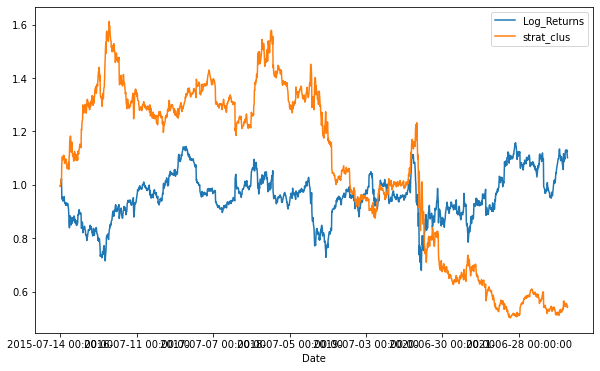

In [119]:
test[['Log_Returns', 'strat_clus']].cumsum(
).apply(np.exp).plot(figsize=(10, 6));

In [120]:
accuracy_score(train["direction"], train['pos_clus'])

0.4874709377421855

In [121]:
accuracy_score(test["direction"], test['pos_clus'])

0.48614457831325303

In [122]:
df_train_IBM = train[['AdjClose', 'Log_Returns']]
df_test_IBM = test[['AdjClose', 'Log_Returns']]

In [123]:
df_train_IBM['K_means'] = train['pos_clus']
df_test_IBM['K_means'] = test['pos_clus']

/var/folders/lc/hpq1rlgx6p1fkn9fvvqk3p880000gn/T/ipykernel_13165/3070365564.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_IBM['K_means'] = train['pos_clus']
/var/folders/lc/hpq1rlgx6p1fkn9fvvqk3p880000gn/T/ipykernel_13165/3070365564.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_IBM['K_means'] = test['pos_clus']


 # SMA

In [124]:
train.dropna(inplace=True)
train['Position_7_10'] = np.where(train["avg7"]>train["avg10"],1,-1)
train['Position_7_50'] = np.where(train["avg7"]>train["avg50"],-1,1)
train['Position_10_50'] = np.where(train["avg10"]>train["avg50"],1,-1)
train['Position_7_200'] = np.where(train["avg7"]>train["avg200"],-1,1)
train['Position_10_200'] = np.where(train["avg10"]>train["avg200"],1,-1)
train['Position_50_200'] = np.where(train["avg50"]>train["avg200"],1,-1)
train['Position_7_100'] = np.where(train["avg7"]>train["avg100"],-1,1)
train['Position_10_100'] = np.where(train["avg10"]>train["avg100"],1,-1)
train['Position_50_100'] = np.where(train["avg50"]>train["avg100"],1,-1)
train['Position_100_200'] = np.where(train["avg100"]>train["avg200"],1,-1)

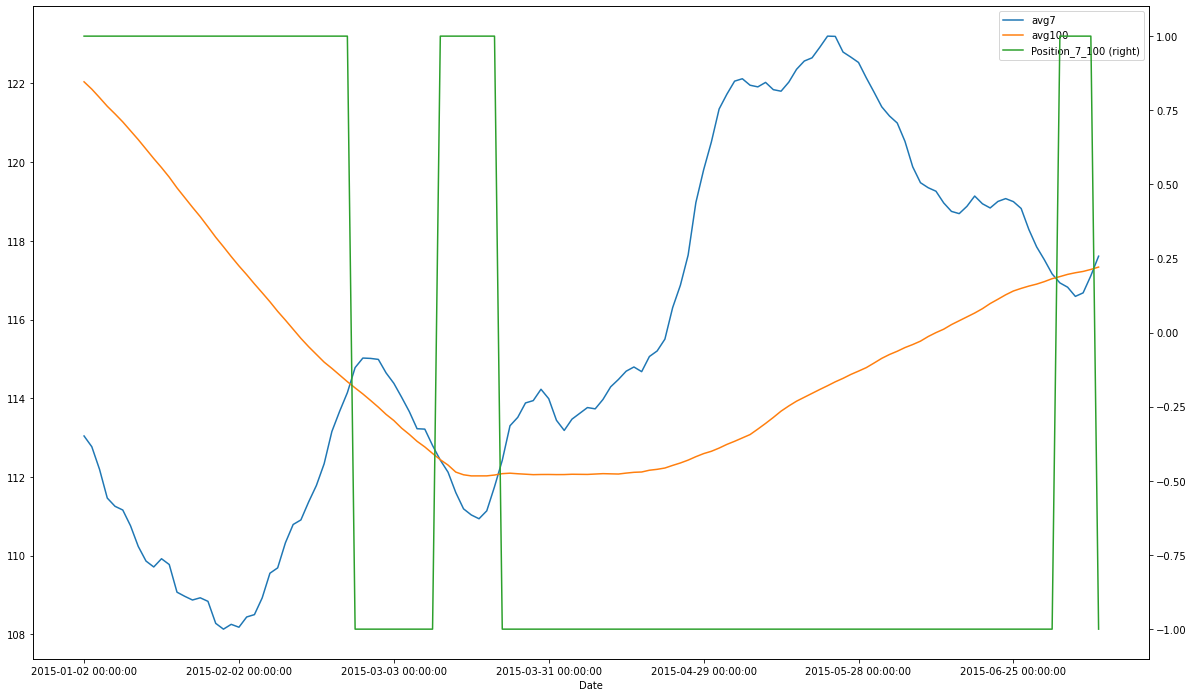

In [125]:
dftrain = train[['avg7','avg100','Position_7_100']]
dftrain1 = dftrain.loc['2015-01-01':]
ax = dftrain1.plot(secondary_y='Position_7_100', figsize=(20, 12))

In [126]:
test.dropna(inplace=True)
test['Position_7_10'] = np.where(test["avg7"]>test["avg10"],1,-1)
test['Position_7_50'] = np.where(test["avg7"]>test["avg50"],-1,1)
test['Position_10_50'] = np.where(test["avg10"]>test["avg50"],1,-1)
test['Position_7_200'] = np.where(test["avg7"]>test["avg200"],-1,1)
test['Position_10_200'] = np.where(test["avg10"]>test["avg200"],1,-1)
test['Position_50_200'] = np.where(test["avg50"]>test["avg200"],1,-1)
test['Position_10_50'] = np.where(test["avg10"]>test["avg50"],-1,1)
test['Position_7_100'] = np.where(test["avg7"]>test["avg100"],-1,1)
test['Position_10_100'] = np.where(test["avg10"]>test["avg100"],1,-1)
test['Position_50_100'] = np.where(test["avg50"]>test["avg100"],1,-1)
test['Position_100_200'] = np.where(test["avg100"]>test["avg200"],1,-1)

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


<AxesSubplot:xlabel='Date'>

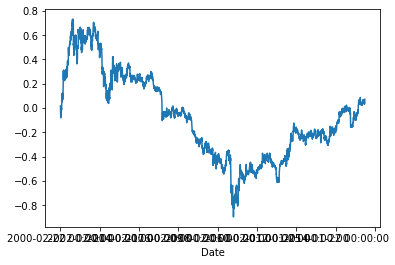

In [127]:
#Create an "empty" column as placeholder for our /position signals
train['PositionBB'] = None
#Fill our newly created position column - set to sell (-1) when the price hits the upper band, and set to buy (1) when it hits the lower band
for row in range(len(train)):

    if (train['AdjClose'].iloc[row] > train ['upperband'].iloc[row]) and (train ['AdjClose'].iloc[row-1] < train ['upperband'].iloc[row-1]):
        train['PositionBB'].iloc[row] = -1

    if (train ['AdjClose'].iloc[row] < train ['lowerband'].iloc[row]) and (train ['AdjClose'].iloc[row-1] > train ['lowerband'].iloc[row-1]):
        train ['PositionBB'].iloc[row] = 1
#Forward fill our position column to replace the "None" values with the correct long/short positions to represent the "holding" of our position
#forward through time
train['PositionBB'].fillna(method='ffill',inplace=True)
#Calculate the daily market return and multiply that by the position to determine strategy returns
train['Strategy_Return_BB'] = train ['Log_Returns'] * train ['PositionBB'].shift(1)
#Plot the strategy returns
train['Strategy_Return_BB'].cumsum().plot()

In [128]:
df_train_IBM['PositionBB'] = train['PositionBB']

/var/folders/lc/hpq1rlgx6p1fkn9fvvqk3p880000gn/T/ipykernel_13165/598857448.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_IBM['PositionBB'] = train['PositionBB']


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


<AxesSubplot:xlabel='Date'>

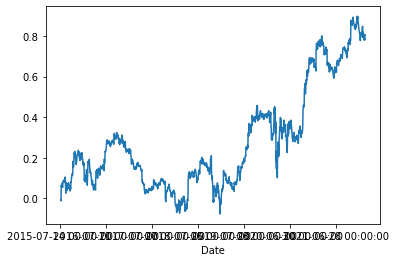

In [129]:
#Create an "empty" column as placeholder for our /position signals
test['PositionBB'] = None
#Fill our newly created position column - set to sell (-1) when the price hits the upper band, and set to buy (1) when it hits the lower band
for row in range(len(test)):

    if (test['AdjClose'].iloc[row] > test ['upperband'].iloc[row]) and (test ['AdjClose'].iloc[row-1] < test ['upperband'].iloc[row-1]):
        test['PositionBB'].iloc[row] = -1

    if (test ['AdjClose'].iloc[row] < test ['lowerband'].iloc[row]) and (test ['AdjClose'].iloc[row-1] > test ['lowerband'].iloc[row-1]):
        test ['PositionBB'].iloc[row] = 1
#Forward fill our position column to replace the "None" values with the correct long/short positions to represent the "holding" of our position
#forward through time
test['PositionBB'].fillna(method='ffill',inplace=True)
#Calculate the daily market return and multiply that by the position to determine strategy returns
test['Strategy_Return_BB'] = test ['Log_Returns'] * test ['PositionBB'].shift(1)
#Plot the strategy returns
test['Strategy_Return_BB'].cumsum().plot()

In [130]:
df_test_IBM['PositionBB'] = test['PositionBB']

/var/folders/lc/hpq1rlgx6p1fkn9fvvqk3p880000gn/T/ipykernel_13165/2594668764.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_IBM['PositionBB'] = test['PositionBB']


In [131]:
X_train_IBM = train[['Position_7_50', 'Position_10_50', 'Position_7_200', 'Position_10_200', 'Position_50_200','Position_7_100','Position_10_100','Position_50_100','Position_100_200']]
y_train_IBM = train['direction']
X_valid_IBM = test[['Position_7_50', 'Position_10_50', 'Position_7_200', 'Position_10_200', 'Position_50_200','Position_7_100','Position_10_100','Position_50_100','Position_100_200']]
y_valid_IBM = test['direction']

In [132]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

rf_IBM = RandomForestClassifier(n_estimators=100,
                            n_jobs=-1,
                            random_state=42)

rf_IBM.fit(X_train_IBM, y_train_IBM)
y_pred_IBM = rf_IBM.predict(X_valid_IBM)
y_pred1_IBM = rf_IBM.predict(X_train_IBM)

print('Score Train: ', rf_IBM.score(X_train_IBM, y_train_IBM))
print('Score Test: ', rf_IBM.score(X_valid_IBM, y_valid_IBM))

Score Train:  0.5365538620511495
Score Test:  0.5204819277108433


In [133]:
df_train_IBM['y_pred'] = y_pred1_IBM
df_test_IBM['y_pred'] = y_pred_IBM

/var/folders/lc/hpq1rlgx6p1fkn9fvvqk3p880000gn/T/ipykernel_13165/1000567697.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_IBM['y_pred'] = y_pred1_IBM
/var/folders/lc/hpq1rlgx6p1fkn9fvvqk3p880000gn/T/ipykernel_13165/1000567697.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_IBM['y_pred'] = y_pred_IBM


In [134]:
data = {'Algorithm': ['K-means','y_pred','PositionBB'], 
        'Accuracy_train': [acc_train_kmeans, acc2_log_reg_test,acc2_gauss_nb_train,acc2_gauss_nb_test,acc2_svm_train,acc2_svm_test], 
        'Accuracy_test':[acc_test_kmeans,two_perf_test[2],two_perf_train[3],two_perf_test[3],two_perf_train[4],two_perf_test[4]],
        'Performance_train' : ,
        'Performance_test': }
table_freq = pd.DataFrame(data)
table_freq

SyntaxError: invalid syntax (3326681861.py, line 4)

In [ ]:
df_train_IBM.to_excel(r'/Users/macbook/Desktop/Hanna/IBM_train.xlsx')

In [ ]:
df_test_IBM.to_excel(r'/Users/macbook/Desktop/Hanna/IBM_test.xlsx')

# NASDAQ

In [135]:
NASDAQ_final = pd.read_csv("/Users/macbook/Downloads/NASDAQ.csv")
NASDAQ_final.set_index('Date', inplace = True)

In [136]:
NASDAQ_final['direction'] = np.sign(NASDAQ_final['Adj_Close_Returns']).astype(int)

In [137]:
train_pct_index = int(0.7*len(NASDAQ_final))
train, test = NASDAQ_final[:train_pct_index],NASDAQ_final[train_pct_index:]

In [138]:
create_lags(train)
create_lags(test)

/var/folders/lc/hpq1rlgx6p1fkn9fvvqk3p880000gn/T/ipykernel_13165/1615434950.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data['Log_Returns'].shift(lag)


In [139]:
train = train.fillna(0)
test = test.fillna(0)

In [140]:
model = KMeans(n_clusters=2, random_state=0) 
model.fit(train[cols])
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
n_clusters=2, n_init=10,
random_state=0, tol=0.0001, verbose=0)

KMeans(n_clusters=2, random_state=0)

In [141]:
train['pos_clus'] = model.predict(train[cols])
test['pos_clus'] = model.predict(test[cols])
train['pos_clus'] = np.where(train['pos_clus'] == 1, 1, -1) 
test['pos_clus'] = np.where(test['pos_clus'] == 1, 1, -1) 

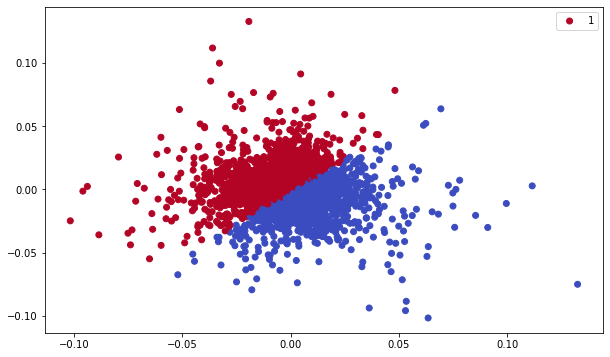

In [142]:
plt.figure(figsize=(10, 6))
plt.scatter(train[cols].iloc[:, 0], train[cols].iloc[:, 1],
c=train['pos_clus'], cmap='coolwarm', label = train['pos_clus'])
plt.legend(train['pos_clus'])
plt.show()

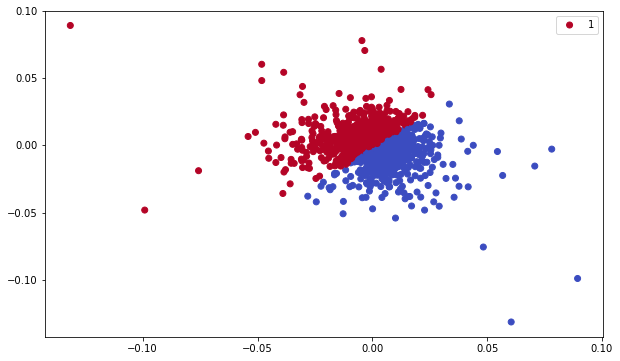

In [143]:
plt.figure(figsize=(10, 6))
plt.scatter(test[cols].iloc[:, 0], test[cols].iloc[:, 1],
c=test['pos_clus'], cmap='coolwarm', label = test['pos_clus'])
plt.legend(test['pos_clus'])
plt.show()

In [144]:
train['strat_clus'] = train['pos_clus'] * train['Log_Returns']
test['strat_clus'] = test['pos_clus'] * test['Log_Returns']

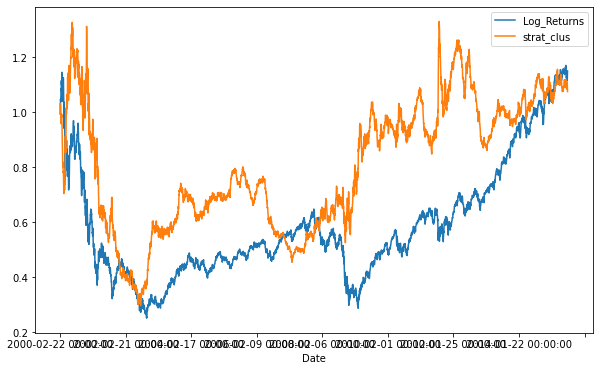

In [145]:
train[['Log_Returns', 'strat_clus']].cumsum(
).apply(np.exp).plot(figsize=(10, 6));

<AxesSubplot:xlabel='Date'>

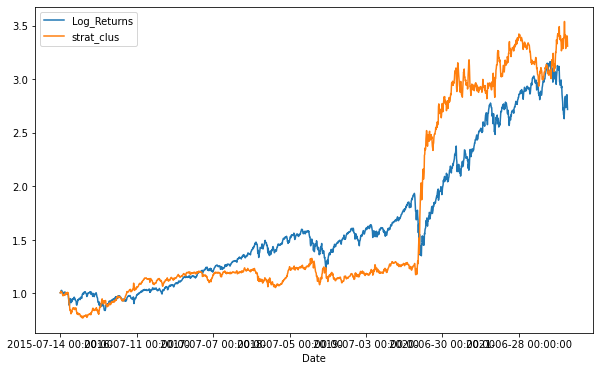

In [146]:
test[['Log_Returns','strat_clus']].cumsum().apply(np.exp).plot(figsize=(10,6))

In [147]:
accuracy_score(train["direction"], train['pos_clus'])

0.4983208473262723

In [148]:
accuracy_score(test["direction"], test['pos_clus'])

0.5373493975903615

In [149]:
df_train_NASDAQ = train[['AdjClose', 'Log_Returns']]
df_test_NASDAQ = test[['AdjClose', 'Log_Returns']]

In [150]:
df_train_NASDAQ['K_means'] = train['pos_clus']
df_test_NASDAQ['K_means'] = test['pos_clus']

/var/folders/lc/hpq1rlgx6p1fkn9fvvqk3p880000gn/T/ipykernel_13165/1610187894.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_NASDAQ['K_means'] = train['pos_clus']
/var/folders/lc/hpq1rlgx6p1fkn9fvvqk3p880000gn/T/ipykernel_13165/1610187894.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_NASDAQ['K_means'] = test['pos_clus']


In [151]:
train.dropna(inplace=True)
train['Position_7_10'] = np.where(train["avg7"]>train["avg10"],1,-1)
train['Position_7_50'] = np.where(train["avg7"]>train["avg50"],-1,1)
train['Position_10_50'] = np.where(train["avg10"]>train["avg50"],1,-1)
train['Position_7_200'] = np.where(train["avg7"]>train["avg200"],-1,1)
train['Position_10_200'] = np.where(train["avg10"]>train["avg200"],1,-1)
train['Position_50_200'] = np.where(train["avg50"]>train["avg200"],1,-1)
train['Position_10_50'] = np.where(train["avg10"]>train["avg50"],-1,1)
train['Position_7_100'] = np.where(train["avg7"]>train["avg100"],-1,1)
train['Position_10_100'] = np.where(train["avg10"]>train["avg100"],1,-1)
train['Position_50_100'] = np.where(train["avg50"]>train["avg100"],1,-1)
train['Position_100_200'] = np.where(train["avg100"]>train["avg200"],1,-1)
test.dropna(inplace=True)
test['Position_7_10'] = np.where(test["avg7"]>test["avg10"],1,-1)
test['Position_7_50'] = np.where(test["avg7"]>test["avg50"],-1,1)
test['Position_10_50'] = np.where(test["avg10"]>test["avg50"],1,-1)
test['Position_7_200'] = np.where(test["avg7"]>test["avg200"],-1,1)
test['Position_10_200'] = np.where(test["avg10"]>test["avg200"],1,-1)
test['Position_50_200'] = np.where(test["avg50"]>test["avg200"],1,-1)
test['Position_10_50'] = np.where(test["avg10"]>test["avg50"],-1,1)
test['Position_7_100'] = np.where(test["avg7"]>test["avg100"],-1,1)
test['Position_10_100'] = np.where(test["avg10"]>test["avg100"],1,-1)
test['Position_50_100'] = np.where(test["avg50"]>test["avg100"],1,-1)
test['Position_100_200'] = np.where(test["avg100"]>test["avg200"],1,-1)


In [152]:
#df_train_NASDAQ['Position_7_50'] = train['Position_7_50']
#df_train_NASDAQ['Position_10_50'] = train['Position_10_50']
#df_train_NASDAQ['Position_7_200'] = train['Position_7_200']
#df_train_NASDAQ['Position_10_200'] = train['Position_10_200']
#df_train_NASDAQ['Position_50_200'] = train['Position_50_200']
#df_train_NASDAQ['Position_10_50'] = train['Position_10_50']
#df_train_NASDAQ['Position_7_100'] = train['Position_7_100']
#df_train_NASDAQ['Position_10_100'] = train['Position_10_100']
#df_train_NASDAQ['Position_50_100'] = train['Position_50_100']
#df_train_NASDAQ['Position_100_200'] = train['Position_100_200']

In [153]:
#df_test_NASDAQ['Position_7_50'] = test['Position_7_50']
#df_test_NASDAQ['Position_10_50'] = test['Position_10_50']
#df_test_NASDAQ['Position_7_200'] = test['Position_7_200']
#df_test_NASDAQ['Position_10_200'] = test['Position_10_200']
#df_test_NASDAQ['Position_50_200'] = test['Position_50_200']
#df_test_NASDAQ['Position_10_50'] = test['Position_10_50']
#df_test_NASDAQ['Position_7_100'] = test['Position_7_100']
#df_test_NASDAQ['Position_10_100'] = test['Position_10_100']
#df_test_NASDAQ['Position_50_100'] = test['Position_50_100']
#df_test_NASDAQ['Position_100_200'] = test['Position_100_200']

In [154]:
corr = df_train_NASDAQ.corr()
corr

,AdjClose,Log_Returns,K_means
AdjClose,1.000000,0.026468,0.022185
Log_Returns,0.026468,1.000000,0.000824
K_means,0.022185,0.000824,1.000000


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


<AxesSubplot:xlabel='Date'>

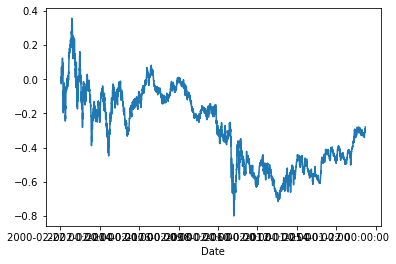

In [155]:
train['PositionBB'] = None
#Fill our newly created position column - set to sell (-1) when the price hits the upper band, and set to buy (1) when it hits the lower band
for row in range(len(train)):

    if (train['AdjClose'].iloc[row] > train ['upperband'].iloc[row]) and (train ['AdjClose'].iloc[row-1] < train ['upperband'].iloc[row-1]):
        train['PositionBB'].iloc[row] = -1

    if (train ['AdjClose'].iloc[row] < train ['lowerband'].iloc[row]) and (train ['AdjClose'].iloc[row-1] > train ['lowerband'].iloc[row-1]):
        train ['PositionBB'].iloc[row] = 1
#Forward fill our position column to replace the "None" values with the correct long/short positions to represent the "holding" of our position
#forward through time
train['PositionBB'].fillna(method='ffill',inplace=True)
#Calculate the daily market return and multiply that by the position to determine strategy returns
train['Strategy_Return_BB'] = train ['Log_Returns'] * train ['PositionBB'].shift(1)
#Plot the strategy returns
train['Strategy_Return_BB'].cumsum().plot()

In [156]:
df_train_NASDAQ['PositionBB'] = train['PositionBB']

/var/folders/lc/hpq1rlgx6p1fkn9fvvqk3p880000gn/T/ipykernel_13165/1313965673.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_NASDAQ['PositionBB'] = train['PositionBB']


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


<AxesSubplot:xlabel='Date'>

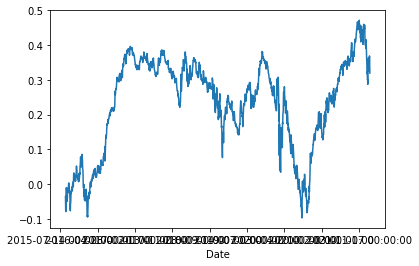

In [157]:
test['PositionBB'] = None
#Fill our newly created position column - set to sell (-1) when the price hits the upper band, and set to buy (1) when it hits the lower band
for row in range(len(test)):

    if (test['AdjClose'].iloc[row] > test ['upperband'].iloc[row]) and (test ['AdjClose'].iloc[row-1] < test ['upperband'].iloc[row-1]):
        test['PositionBB'].iloc[row] = -1

    if (test ['AdjClose'].iloc[row] < test ['lowerband'].iloc[row]) and (test ['AdjClose'].iloc[row-1] > test ['lowerband'].iloc[row-1]):
        test ['PositionBB'].iloc[row] = 1
#Forward fill our position column to replace the "None" values with the correct long/short positions to represent the "holding" of our position
#forward through time
test['PositionBB'].fillna(method='ffill',inplace=True)
#Calculate the daily market return and multiply that by the position to determine strategy returns
test['Strategy_Return_BB'] = test ['Log_Returns'] * test ['PositionBB'].shift(1)
#Plot the strategy returns
test['Strategy_Return_BB'].cumsum().plot()

In [158]:
df_test_NASDAQ['PositionBB'] = test['PositionBB']

/var/folders/lc/hpq1rlgx6p1fkn9fvvqk3p880000gn/T/ipykernel_13165/1689158278.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_NASDAQ['PositionBB'] = test['PositionBB']


In [159]:
X_train_NASDAQ = train[['Position_7_50', 'Position_10_50', 'Position_7_200', 'Position_10_200', 'Position_50_200','Position_7_100','Position_10_100','Position_50_100','Position_100_200']]
y_train_NASDAQ = train['direction']
X_valid_NASDAQ = test[['Position_7_50', 'Position_10_50', 'Position_7_200', 'Position_10_200', 'Position_50_200','Position_7_100','Position_10_100','Position_50_100','Position_100_200']]
y_valid_NASDAQ = test['direction']

In [160]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

rf_NASDAQ = RandomForestClassifier(n_estimators=100,
                            n_jobs=-1,
                            random_state=42)

rf_NASDAQ.fit(X_train_NASDAQ, y_train_NASDAQ)
y_pred_NASDAQ = rf_NASDAQ.predict(X_valid_NASDAQ)
y_pred1_NASDAQ = rf_NASDAQ.predict(X_train_NASDAQ)

print('Score Train: ', rf_NASDAQ.score(X_train_NASDAQ, y_train_NASDAQ))
print('Score Test: ', rf_NASDAQ.score(X_valid_NASDAQ, y_valid_NASDAQ))

Score Train:  0.5528287264272798
Score Test:  0.5524096385542169


In [161]:
df_train_NASDAQ['y_pred'] = y_pred1_NASDAQ
df_test_NASDAQ['y_pred'] = y_pred_NASDAQ

/var/folders/lc/hpq1rlgx6p1fkn9fvvqk3p880000gn/T/ipykernel_13165/3577579010.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_NASDAQ['y_pred'] = y_pred1_NASDAQ
/var/folders/lc/hpq1rlgx6p1fkn9fvvqk3p880000gn/T/ipykernel_13165/3577579010.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_NASDAQ['y_pred'] = y_pred_NASDAQ


In [162]:
df_train_NASDAQ
df_test_NASDAQ.corr()

,AdjClose,Log_Returns,K_means,PositionBB,y_pred
AdjClose,1.000000,0.022085,-0.022318,0.084840,0.252292
Log_Returns,0.022085,1.000000,0.047012,-0.037859,-0.005512
K_means,-0.022318,0.047012,1.000000,-0.028422,0.006872
PositionBB,0.084840,-0.037859,-0.028422,1.000000,-0.244011
y_pred,0.252292,-0.005512,0.006872,-0.244011,1.000000


# GDL

In [163]:
GLD_final = pd.read_csv("/Users/macbook/Downloads/GLD.csv")

In [164]:
GLD_final.set_index('Date', inplace = True)

In [165]:
train_pct_index = int(0.7*len(GLD_final))
train, test = GLD_final[:train_pct_index],GLD_final[train_pct_index:]

In [166]:
create_lags(train)
create_lags(test)

/var/folders/lc/hpq1rlgx6p1fkn9fvvqk3p880000gn/T/ipykernel_13165/1615434950.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data['Log_Returns'].shift(lag)


In [167]:
train = train.fillna(0)
test = test.fillna(0)

In [168]:
model = KMeans(n_clusters=2, random_state=0) 
model.fit(train[cols])
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
n_clusters=2, n_init=10,
random_state=0, tol=0.0001, verbose=0)

KMeans(n_clusters=2, random_state=0)

In [169]:
train['pos_clus'] = model.predict(train[cols])
test['pos_clus'] = model.predict(test[cols])
train['pos_clus'] = np.where(train['pos_clus'] == 1, -1, 1) 
test['pos_clus'] = np.where(test['pos_clus'] == 1, -1, 1) 

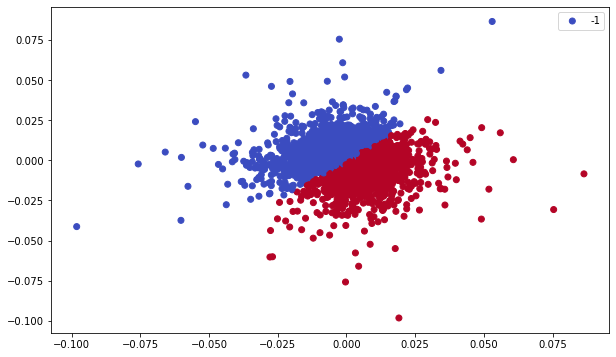

In [170]:
plt.figure(figsize=(10, 6))
plt.scatter(train[cols].iloc[:, 0], train[cols].iloc[:, 1],
c=train['pos_clus'], cmap='coolwarm', label = train['pos_clus'])
plt.legend(train['pos_clus'])
plt.show()

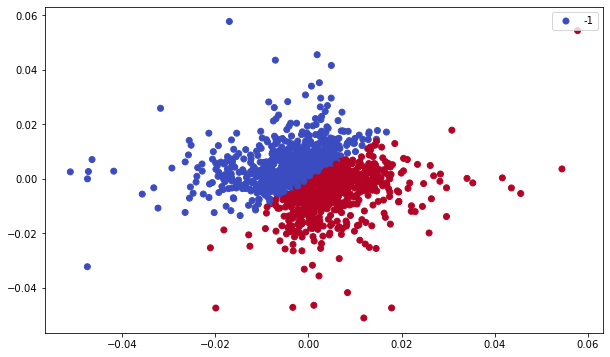

In [171]:
plt.figure(figsize=(10, 6))
plt.scatter(test[cols].iloc[:, 0], test[cols].iloc[:, 1],
c=test['pos_clus'], cmap='coolwarm', label = test['pos_clus'])
plt.legend(test['pos_clus'])
plt.show()

In [172]:
train['strat_clus'] = train['pos_clus'] * train['Log_Returns']
test['strat_clus'] = test['pos_clus'] * test['Log_Returns']

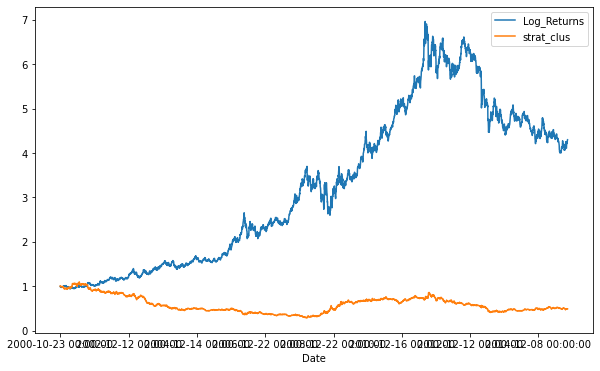

In [173]:
train[['Log_Returns', 'strat_clus']].cumsum(
).apply(np.exp).plot(figsize=(10, 6));

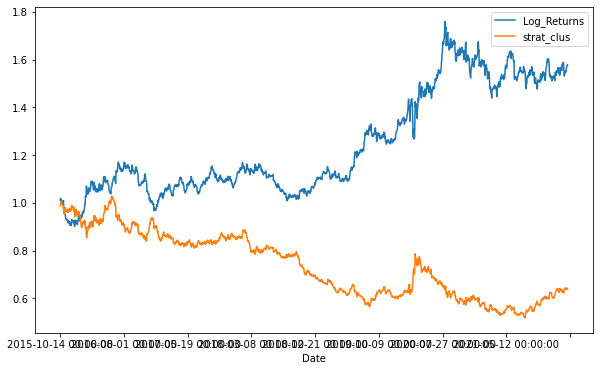

In [174]:
test[['Log_Returns', 'strat_clus']].cumsum(
).apply(np.exp).plot(figsize=(10, 6));

In [175]:
accuracy_score(train["direction"], train['pos_clus'])

0.4800753904146473

In [176]:
accuracy_score(test["direction"], test['pos_clus'])

0.4934086629001883

In [177]:
df_train_GLD = train[['AdjClose', 'Log_Returns']]
df_test_GLD = test[['AdjClose', 'Log_Returns']]
df_train_GLD['K_means'] = train['pos_clus']
df_test_GLD['K_means'] = test['pos_clus']

/var/folders/lc/hpq1rlgx6p1fkn9fvvqk3p880000gn/T/ipykernel_13165/1690550691.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_GLD['K_means'] = train['pos_clus']
/var/folders/lc/hpq1rlgx6p1fkn9fvvqk3p880000gn/T/ipykernel_13165/1690550691.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_GLD['K_means'] = test['pos_clus']


In [178]:
train.dropna(inplace=True)
train['Position_7_10'] = np.where(train["avg7"]>train["avg10"],1,-1)
train['Position_7_50'] = np.where(train["avg7"]>train["avg50"],-1,1)
train['Position_10_50'] = np.where(train["avg10"]>train["avg50"],1,-1)
train['Position_7_200'] = np.where(train["avg7"]>train["avg200"],-1,1)
train['Position_10_200'] = np.where(train["avg10"]>train["avg200"],1,-1)
train['Position_50_200'] = np.where(train["avg50"]>train["avg200"],1,-1)
train['Position_10_50'] = np.where(train["avg10"]>train["avg50"],-1,1)
train['Position_7_100'] = np.where(train["avg7"]>train["avg100"],-1,1)
train['Position_10_100'] = np.where(train["avg10"]>train["avg100"],1,-1)
train['Position_50_100'] = np.where(train["avg50"]>train["avg100"],1,-1)
train['Position_100_200'] = np.where(train["avg100"]>train["avg200"],1,-1)
test.dropna(inplace=True)
test['Position_7_10'] = np.where(test["avg7"]>test["avg10"],1,-1)
test['Position_7_50'] = np.where(test["avg7"]>test["avg50"],-1,1)
test['Position_10_50'] = np.where(test["avg10"]>test["avg50"],1,-1)
test['Position_7_200'] = np.where(test["avg7"]>test["avg200"],-1,1)
test['Position_10_200'] = np.where(test["avg10"]>test["avg200"],1,-1)
test['Position_50_200'] = np.where(test["avg50"]>test["avg200"],1,-1)
test['Position_10_50'] = np.where(test["avg10"]>test["avg50"],-1,1)
test['Position_7_100'] = np.where(test["avg7"]>test["avg100"],-1,1)
test['Position_10_100'] = np.where(test["avg10"]>test["avg100"],1,-1)
test['Position_50_100'] = np.where(test["avg50"]>test["avg100"],1,-1)
test['Position_100_200'] = np.where(test["avg100"]>test["avg200"],1,-1)


In [179]:
#df_train_GLD['Position_7_50'] = train['Position_7_50']
#df_train_GLD['Position_10_50'] = train['Position_10_50']
#df_train_GLD['Position_7_200'] = train['Position_7_200']
#df_train_GLD['Position_10_200'] = train['Position_10_200']
#df_train_GLD['Position_50_200'] = train['Position_50_200']
#df_train_GLD['Position_10_50'] = train['Position_10_50']
#df_train_GLD['Position_7_100'] = train['Position_7_100']
#df_train_GLD['Position_10_100'] = train['Position_10_100']
#df_train_GLD['Position_50_100'] = train['Position_50_100']
#df_train_GLD['Position_100_200'] = train['Position_100_200']

In [180]:
#df_test_GLD['Position_7_50'] = test['Position_7_50']
#df_test_GLD['Position_10_50'] = test['Position_10_50']
#df_test_GLD['Position_7_200'] = test['Position_7_200']
#df_test_GLD['Position_10_200'] = test['Position_10_200']
#df_test_GLD['Position_50_200'] = test['Position_50_200']
#df_test_GLD['Position_10_50'] = test['Position_10_50']
#df_test_GLD['Position_7_100'] = test['Position_7_100']
#df_test_GLD['Position_10_100'] = test['Position_10_100']
#df_test_GLD['Position_50_100'] = test['Position_50_100']
#df_test_GLD['Position_100_200'] = test['Position_100_200']

In [181]:
corr = df_train_GLD.corr()
corr

,AdjClose,Log_Returns,K_means
AdjClose,1.000000,-0.007099,-0.006268
Log_Returns,-0.007099,1.000000,-0.014867
K_means,-0.006268,-0.014867,1.000000


In [182]:
df_train_GLD.to_excel(r'/Users/macbook/Desktop/Hanna/GLD_train.xlsx')
df_test_GLD.to_excel(r'/Users/macbook/Desktop/Hanna/GLD_test.xlsx')

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


<AxesSubplot:xlabel='Date'>

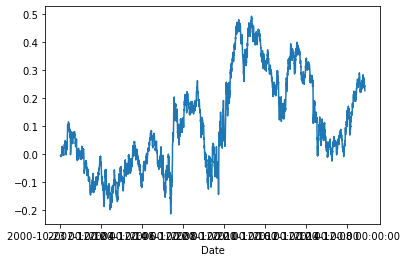

In [183]:
train['PositionBB'] = None
#Fill our newly created position column - set to sell (-1) when the price hits the upper band, and set to buy (1) when it hits the lower band
for row in range(len(train)):

    if (train['AdjClose'].iloc[row] > train ['upperband'].iloc[row]) and (train ['AdjClose'].iloc[row-1] < train ['upperband'].iloc[row-1]):
        train['PositionBB'].iloc[row] = -1

    if (train ['AdjClose'].iloc[row] < train ['lowerband'].iloc[row]) and (train ['AdjClose'].iloc[row-1] > train ['lowerband'].iloc[row-1]):
        train ['PositionBB'].iloc[row] = 1
#Forward fill our position column to replace the "None" values with the correct long/short positions to represent the "holding" of our position
#forward through time
train['PositionBB'].fillna(method='ffill',inplace=True)
#Calculate the daily market return and multiply that by the position to determine strategy returns
train['Strategy_Return_BB'] = train ['Log_Returns'] * train ['PositionBB'].shift(1)
#Plot the strategy returns
train['Strategy_Return_BB'].cumsum().plot()

In [184]:
df_train_GLD['PositionBB'] = train['PositionBB']

/var/folders/lc/hpq1rlgx6p1fkn9fvvqk3p880000gn/T/ipykernel_13165/558472324.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_GLD['PositionBB'] = train['PositionBB']


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


<AxesSubplot:xlabel='Date'>

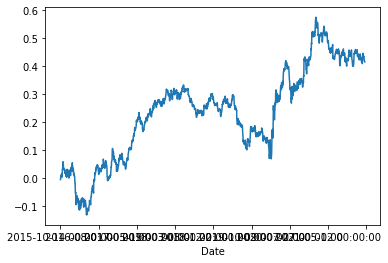

In [185]:
test['PositionBB'] = None
#Fill our newly created position column - set to sell (-1) when the price hits the upper band, and set to buy (1) when it hits the lower band
for row in range(len(test)):

    if (test['AdjClose'].iloc[row] > test ['upperband'].iloc[row]) and (test ['AdjClose'].iloc[row-1] < test ['upperband'].iloc[row-1]):
        test['PositionBB'].iloc[row] = -1

    if (test ['AdjClose'].iloc[row] < test ['lowerband'].iloc[row]) and (test ['AdjClose'].iloc[row-1] > test ['lowerband'].iloc[row-1]):
        test ['PositionBB'].iloc[row] = 1
#Forward fill our position column to replace the "None" values with the correct long/short positions to represent the "holding" of our position
#forward through time
test['PositionBB'].fillna(method='ffill',inplace=True)
#Calculate the daily market return and multiply that by the position to determine strategy returns
test['Strategy_Return_BB'] = test ['Log_Returns'] * test ['PositionBB'].shift(1)
#Plot the strategy returns
test['Strategy_Return_BB'].cumsum().plot()

In [186]:
df_test_GLD['PositionBB'] = test['PositionBB']

/var/folders/lc/hpq1rlgx6p1fkn9fvvqk3p880000gn/T/ipykernel_13165/3208096023.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_GLD['PositionBB'] = test['PositionBB']


In [187]:
X_train_GLD = train[['Position_7_50', 'Position_10_50', 'Position_7_200', 'Position_10_200', 'Position_50_200','Position_7_100','Position_10_100','Position_50_100','Position_100_200']]
y_train_GLD = train['direction']
X_valid_GLD = test[['Position_7_50', 'Position_10_50', 'Position_7_200', 'Position_10_200', 'Position_50_200','Position_7_100','Position_10_100','Position_50_100','Position_100_200']]
y_valid_GLD = test['direction']

In [188]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

rf_GLD = RandomForestClassifier(n_estimators=100,
                            n_jobs=-1,
                            random_state=42)

rf_GLD.fit(X_train_GLD, y_train_GLD)
y_pred_GLD = rf_GLD.predict(X_valid_GLD)
y_pred1_GLD = rf_GLD.predict(X_train_GLD)

print('Score Train: ', rf_GLD.score(X_train_GLD, y_train_GLD))
print('Score Test: ', rf_GLD.score(X_valid_GLD, y_valid_GLD))

Score Train:  0.5584275713516424
Score Test:  0.4908976773383553


In [189]:
df_train_GLD['y_pred'] = y_pred1_GLD
df_test_GLD['y_pred'] = y_pred_GLD

/var/folders/lc/hpq1rlgx6p1fkn9fvvqk3p880000gn/T/ipykernel_13165/810977542.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_GLD['y_pred'] = y_pred1_GLD
/var/folders/lc/hpq1rlgx6p1fkn9fvvqk3p880000gn/T/ipykernel_13165/810977542.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_GLD['y_pred'] = y_pred_GLD


In [190]:
df_train_GLD.corr()

,AdjClose,Log_Returns,K_means,PositionBB,y_pred
AdjClose,1.000000,-0.007099,-0.006268,0.093935,-0.168474
Log_Returns,-0.007099,1.000000,-0.014867,-0.062123,0.056531
K_means,-0.006268,-0.014867,1.000000,-0.000149,-0.010013
PositionBB,0.093935,-0.062123,-0.000149,1.000000,-0.134913
y_pred,-0.168474,0.056531,-0.010013,-0.134913,1.000000


# WTI

In [191]:
WTI_final = pd.read_csv("/Users/macbook/Downloads/WTI.csv")

In [192]:
WTI_final.set_index('Date', inplace = True)

In [193]:
train_pct_index = int(0.7*len(WTI_final))
train, test = WTI_final[:train_pct_index],WTI_final[train_pct_index:]

In [194]:
create_lags(train)
create_lags(test)

/var/folders/lc/hpq1rlgx6p1fkn9fvvqk3p880000gn/T/ipykernel_13165/1615434950.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data['Log_Returns'].shift(lag)


In [195]:
train = train.fillna(0)
test = test.fillna(0)

In [196]:
model = KMeans(n_clusters=2, random_state=0) 
model.fit(train[cols])
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
n_clusters=2, n_init=10,
random_state=0, tol=0.0001, verbose=0)

KMeans(n_clusters=2, random_state=0)

In [197]:
train['pos_clus'] = model.predict(train[cols])
test['pos_clus'] = model.predict(test[cols])
train['pos_clus'] = np.where(train['pos_clus'] == 1, -1, 1) 
test['pos_clus'] = np.where(test['pos_clus'] == 1, -1, 1) 

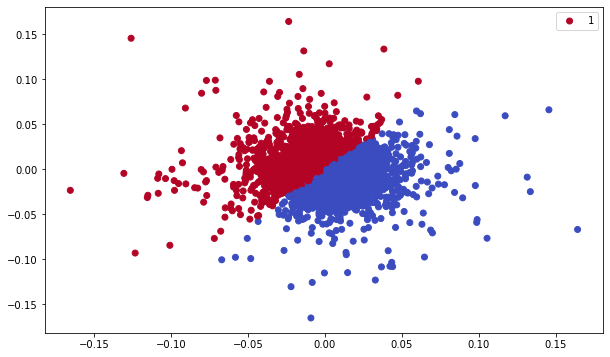

In [198]:
plt.figure(figsize=(10, 6))
plt.scatter(train[cols].iloc[:, 0], train[cols].iloc[:, 1],
c=train['pos_clus'], cmap='coolwarm', label = train['pos_clus'])
plt.legend(train['pos_clus'])
plt.show()

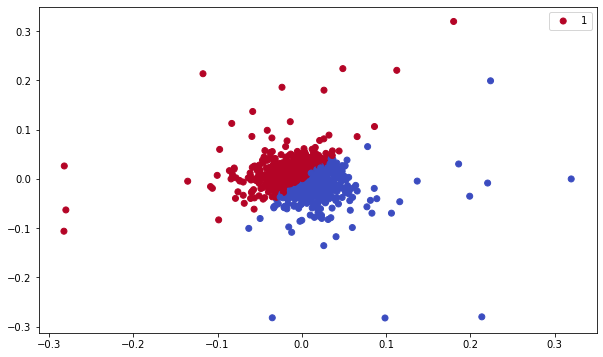

In [199]:
plt.figure(figsize=(10, 6))
plt.scatter(test[cols].iloc[:, 0], test[cols].iloc[:, 1],
c=test['pos_clus'], cmap='coolwarm', label = test['pos_clus'])
plt.legend(test['pos_clus'])
plt.show()

In [200]:
train['strat_clus'] = train['pos_clus'] * train['Log_Returns']
test['strat_clus'] = test['pos_clus'] * test['Log_Returns']

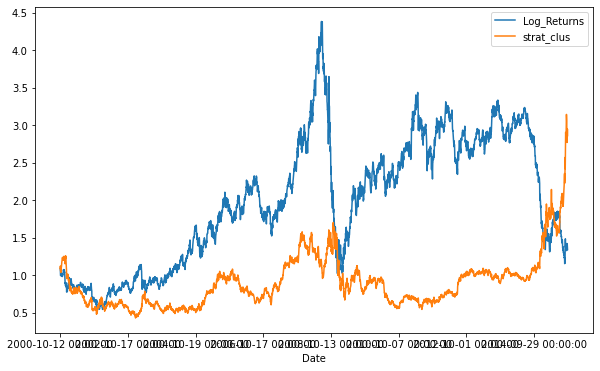

In [201]:
train[['Log_Returns', 'strat_clus']].cumsum(
).apply(np.exp).plot(figsize=(10, 6));

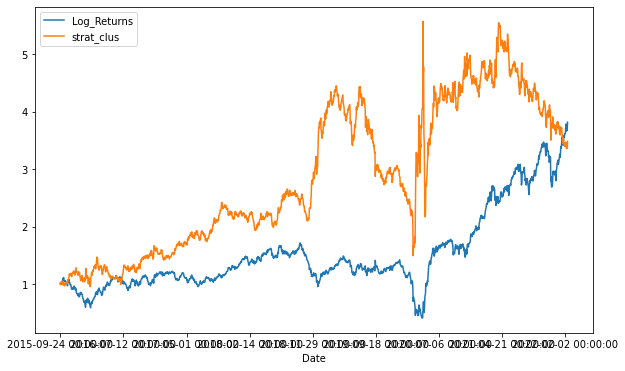

In [202]:
test[['Log_Returns', 'strat_clus']].cumsum(
).apply(np.exp).plot(figsize=(10, 6));

In [203]:
accuracy_score(train["direction"], train['pos_clus'])

0.5142704721259003

In [204]:
accuracy_score(test["direction"], test['pos_clus'])

0.5062189054726368

In [205]:
df_train_WTI = train[['AdjClose', 'Log_Returns']]
df_test_WTI = test[['AdjClose', 'Log_Returns']]
df_train_WTI['K_means'] = train['pos_clus']
df_test_WTI['K_means'] = test['pos_clus']

/var/folders/lc/hpq1rlgx6p1fkn9fvvqk3p880000gn/T/ipykernel_13165/1307041514.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_WTI['K_means'] = train['pos_clus']
/var/folders/lc/hpq1rlgx6p1fkn9fvvqk3p880000gn/T/ipykernel_13165/1307041514.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_WTI['K_means'] = test['pos_clus']


In [206]:
train.dropna(inplace=True)
train['Position_7_10'] = np.where(train["avg7"]>train["avg10"],1,-1)
train['Position_7_50'] = np.where(train["avg7"]>train["avg50"],-1,1)
train['Position_10_50'] = np.where(train["avg10"]>train["avg50"],1,-1)
train['Position_7_200'] = np.where(train["avg7"]>train["avg200"],-1,1)
train['Position_10_200'] = np.where(train["avg10"]>train["avg200"],1,-1)
train['Position_50_200'] = np.where(train["avg50"]>train["avg200"],1,-1)
train['Position_10_50'] = np.where(train["avg10"]>train["avg50"],-1,1)
train['Position_7_100'] = np.where(train["avg7"]>train["avg100"],-1,1)
train['Position_10_100'] = np.where(train["avg10"]>train["avg100"],1,-1)
train['Position_50_100'] = np.where(train["avg50"]>train["avg100"],1,-1)
train['Position_100_200'] = np.where(train["avg100"]>train["avg200"],1,-1)
test.dropna(inplace=True)
test['Position_7_10'] = np.where(test["avg7"]>test["avg10"],1,-1)
test['Position_7_50'] = np.where(test["avg7"]>test["avg50"],-1,1)
test['Position_10_50'] = np.where(test["avg10"]>test["avg50"],1,-1)
test['Position_7_200'] = np.where(test["avg7"]>test["avg200"],-1,1)
test['Position_10_200'] = np.where(test["avg10"]>test["avg200"],1,-1)
test['Position_50_200'] = np.where(test["avg50"]>test["avg200"],1,-1)
test['Position_10_50'] = np.where(test["avg10"]>test["avg50"],-1,1)
test['Position_7_100'] = np.where(test["avg7"]>test["avg100"],-1,1)
test['Position_10_100'] = np.where(test["avg10"]>test["avg100"],1,-1)
test['Position_50_100'] = np.where(test["avg50"]>test["avg100"],1,-1)
test['Position_100_200'] = np.where(test["avg100"]>test["avg200"],1,-1)

In [207]:
#df_train_WTI['Position_7_50'] = train['Position_7_50']
#df_train_WTI['Position_10_50'] = train['Position_10_50']
#df_train_WTI['Position_7_200'] = train['Position_7_200']
#df_train_WTI['Position_10_200'] = train['Position_10_200']
#df_train_WTI['Position_50_200'] = train['Position_50_200']
#df_train_WTI['Position_10_50'] = train['Position_10_50']
#df_train_WTI['Position_7_100'] = train['Position_7_100']
#df_train_WTI['Position_10_100'] = train['Position_10_100']
#df_train_WTI['Position_50_100'] = train['Position_50_100']
#df_train_WTI['Position_100_200'] = train['Position_100_200']

In [208]:
#df_test_WTI['Position_7_50'] = test['Position_7_50']
#df_test_WTI['Position_10_50'] = test['Position_10_50']
#df_test_WTI['Position_7_200'] = test['Position_7_200']
#df_test_WTI['Position_10_200'] = test['Position_10_200']
#df_test_WTI['Position_50_200'] = test['Position_50_200']
#df_test_WTI['Position_10_50'] = test['Position_10_50']
#df_test_WTI['Position_7_100'] = test['Position_7_100']
#df_test_WTI['Position_10_100'] = test['Position_10_100']
#df_test_WTI['Position_50_100'] = test['Position_50_100']
#df_test_WTI['Position_100_200'] = test['Position_100_200']

In [209]:
df_train_WTI.to_excel(r'/Users/macbook/Desktop/Hanna/WTI_train.xlsx')
df_test_WTI.to_excel(r'/Users/macbook/Desktop/Hanna/WTI_train.xlsx')

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


<AxesSubplot:xlabel='Date'>

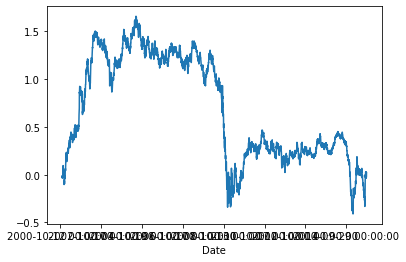

In [210]:
#Create an "empty" column as placeholder for our /position signals
train['PositionBB'] = None
#Fill our newly created position column - set to sell (-1) when the price hits the upper band, and set to buy (1) when it hits the lower band
for row in range(len(train)):

    if (train['AdjClose'].iloc[row] > train ['upperband'].iloc[row]) and (train ['AdjClose'].iloc[row-1] < train ['upperband'].iloc[row-1]):
        train['PositionBB'].iloc[row] = -1

    if (train ['AdjClose'].iloc[row] < train ['lowerband'].iloc[row]) and (train ['AdjClose'].iloc[row-1] > train ['lowerband'].iloc[row-1]):
        train ['PositionBB'].iloc[row] = 1
#Forward fill our position column to replace the "None" values with the correct long/short positions to represent the "holding" of our position
#forward through time
train['PositionBB'].fillna(method='ffill',inplace=True)
#Calculate the daily market return and multiply that by the position to determine strategy returns
train['Strategy_Return_BB'] = train ['Log_Returns'] * train ['PositionBB'].shift(1)
#Plot the strategy returns
train['Strategy_Return_BB'].cumsum().plot()

In [211]:
df_train_WTI['PositionBB'] = train['PositionBB']

/var/folders/lc/hpq1rlgx6p1fkn9fvvqk3p880000gn/T/ipykernel_13165/2701401652.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_WTI['PositionBB'] = train['PositionBB']


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


<AxesSubplot:xlabel='Date'>

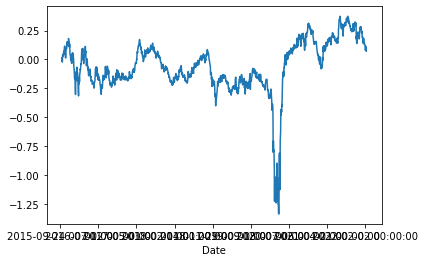

In [212]:
#Create an "empty" column as placeholder for our /position signals
test['PositionBB'] = None
#Fill our newly created position column - set to sell (-1) when the price hits the upper band, and set to buy (1) when it hits the lower band
for row in range(len(test)):

    if (test['AdjClose'].iloc[row] > test ['upperband'].iloc[row]) and (test ['AdjClose'].iloc[row-1] < test ['upperband'].iloc[row-1]):
        test['PositionBB'].iloc[row] = -1

    if (test ['AdjClose'].iloc[row] < test ['lowerband'].iloc[row]) and (test ['AdjClose'].iloc[row-1] > test ['lowerband'].iloc[row-1]):
        test ['PositionBB'].iloc[row] = 1
#Forward fill our position column to replace the "None" values with the correct long/short positions to represent the "holding" of our position
#forward through time
test['PositionBB'].fillna(method='ffill',inplace=True)
#Calculate the daily market return and multiply that by the position to determine strategy returns
test['Strategy_Return_BB'] = test ['Log_Returns'] * test ['PositionBB'].shift(1)
#Plot the strategy returns
test['Strategy_Return_BB'].cumsum().plot()

In [213]:
df_test_WTI['PositionBB'] = test['PositionBB']

/var/folders/lc/hpq1rlgx6p1fkn9fvvqk3p880000gn/T/ipykernel_13165/2674350180.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_WTI['PositionBB'] = test['PositionBB']


In [214]:
X_train_WTI = train[['Position_7_50', 'Position_10_50', 'Position_7_200', 'Position_10_200', 'Position_50_200','Position_7_100','Position_10_100','Position_50_100','Position_100_200']]
y_train_WTI = train['direction']
X_valid_WTI = test[['Position_7_50', 'Position_10_50', 'Position_7_200', 'Position_10_200', 'Position_50_200','Position_7_100','Position_10_100','Position_50_100','Position_100_200']]
y_valid_WTI = test['direction']

In [215]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

rf_WTI = RandomForestClassifier(n_estimators=100,
                            n_jobs=-1,
                            random_state=42)

rf_WTI.fit(X_train_WTI, y_train_WTI)
y_pred_WTI = rf_WTI.predict(X_valid_WTI)
y_pred1_WTI = rf_WTI.predict(X_train_WTI)

print('Score Train: ', rf_WTI.score(X_train_WTI, y_train_WTI))
print('Score Test: ', rf_WTI.score(X_valid_WTI, y_valid_WTI))

Score Train:  0.5454787943451587
Score Test:  0.5286069651741293


In [216]:
df_train_WTI['y_pred'] = y_pred1_WTI
df_test_WTI['y_pred'] = y_pred_WTI

/var/folders/lc/hpq1rlgx6p1fkn9fvvqk3p880000gn/T/ipykernel_13165/3258344603.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_WTI['y_pred'] = y_pred1_WTI
/var/folders/lc/hpq1rlgx6p1fkn9fvvqk3p880000gn/T/ipykernel_13165/3258344603.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_WTI['y_pred'] = y_pred_WTI


In [217]:
df_train_WTI

,AdjClose,Log_Returns,K_means,PositionBB,y_pred
Date,,,,,
2000-10-12 00:00:00,36.099998,0.085250,1,NaN,-1
2000-10-13 00:00:00,35.049999,-0.029517,-1,NaN,-1
2000-10-16 00:00:00,33.099998,-0.057242,1,NaN,-1
2000-10-17 00:00:00,32.950001,-0.004542,1,NaN,-1
2000-10-18 00:00:00,33.549999,0.018046,-1,NaN,-1
...,...,...,...,...,...
2015-09-17 00:00:00,46.900002,-0.005316,-1,-1.0,1
2015-09-18 00:00:00,44.680000,-0.048492,1,-1.0,1
2015-09-21 00:00:00,46.680000,0.043790,1,-1.0,1


In [218]:
IBM_str_train = pd.read_csv("/Users/macbook/Downloads/IBM_startegy_train.csv")
IBM_str_test = pd.read_csv("/Users/macbook/Downloads/IBM_startegy_test.csv")
NASDAQ_str_train = pd.read_csv("/Users/macbook/Downloads/NASDAQ_startegy_train.csv")
NASDAQ_str_test = pd.read_csv("/Users/macbook/Downloads/NASDAQ_startegy_test.csv")
GLD_str_train = pd.read_csv("/Users/macbook/Downloads/GLD_startegy_train.csv")
GLD_str_test = pd.read_csv("/Users/macbook/Downloads/GLD_startegy_test.csv")
WTI_str_train = pd.read_csv("/Users/macbook/Downloads/WTI_startegy_train.csv")
WTI_str_test = pd.read_csv("/Users/macbook/Downloads/WTI_startegy_test.csv")

In [219]:
IBM_str_train.set_index('Date',inplace=True)
IBM_str_test.set_index('Date',inplace=True)
NASDAQ_str_train.set_index('Date',inplace=True)
NASDAQ_str_test.set_index('Date',inplace=True)
GLD_str_train.set_index('Date',inplace=True)
GLD_str_test.set_index('Date',inplace=True)
WTI_str_train.set_index('Date',inplace=True)
WTI_str_test.set_index('Date',inplace=True)

In [220]:
merged_IBM_train = pd.merge(IBM_str_train, df_train_IBM, left_index=True, right_index=True)
merged_IBM_train.drop(['AdjClose','Log_Returns_y'], inplace = True, axis = 1)
merged_IBM_train.rename({'Log_Returns_x':'Log_Returns'}, axis = 1, inplace = True)

In [221]:
merged_IBM_test = pd.merge(IBM_str_test, df_test_IBM, left_index=True, right_index=True)
merged_IBM_test.drop(['Log_Returns_y'], inplace = True, axis = 1)
merged_IBM_test.rename({'Log_Returns_x':'Log_Returns'}, axis = 1, inplace = True)

In [222]:
merged_NASDAQ_train = pd.merge(NASDAQ_str_train, df_train_NASDAQ, left_index=True, right_index=True)
merged_NASDAQ_train.drop(['Log_Returns_y'], inplace = True, axis = 1)
merged_NASDAQ_train.rename({'Log_Returns_x':'Log_Returns'}, axis = 1, inplace = True)

In [223]:
merged_NASDAQ_test = pd.merge(NASDAQ_str_test, df_test_NASDAQ, left_index=True, right_index=True)
merged_NASDAQ_test.drop(['Log_Returns_y'], inplace = True, axis = 1)
merged_NASDAQ_test.rename({'Log_Returns_x':'Log_Returns'}, axis = 1, inplace = True)

In [224]:
merged_GLD_train = pd.merge(GLD_str_train, df_train_GLD, left_index=True, right_index=True)
merged_GLD_train.drop(['Log_Returns_y'], inplace = True, axis = 1)
merged_GLD_train.rename({'Log_Returns_x':'Log_Returns'}, axis = 1, inplace = True)

In [225]:
merged_GLD_test = pd.merge(GLD_str_test, df_test_GLD, left_index=True, right_index=True)
merged_GLD_test.drop(['Log_Returns_y'], inplace = True, axis = 1)
merged_GLD_test.rename({'Log_Returns_x':'Log_Returns'}, axis = 1, inplace = True)

In [226]:
merged_WTI_train = pd.merge(WTI_str_train, df_train_WTI, left_index=True, right_index=True)
merged_WTI_train.drop(['Log_Returns_y'], inplace = True, axis = 1)
merged_WTI_train.rename({'Log_Returns_x':'Log_Returns'}, axis = 1, inplace = True)

In [227]:
merged_WTI_test = pd.merge(WTI_str_test, df_test_WTI, left_index=True, right_index=True)
merged_WTI_test.drop(['Log_Returns_y'], inplace = True, axis = 1)
merged_WTI_test.rename({'Log_Returns_x':'Log_Returns'}, axis = 1, inplace = True)

<AxesSubplot:>

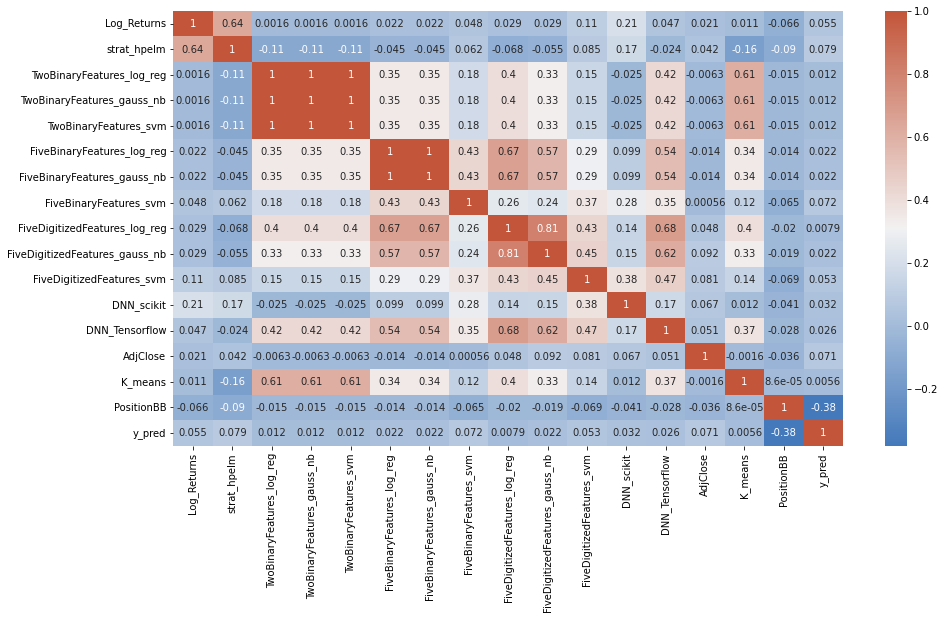

In [179]:
plt.figure(figsize=(15,8))
corr = merged_WTI_train.corr()
cmap = sns.diverging_palette(250, 20, as_cmap=True)
sns.heatmap(corr, xticklabels=corr.columns,
        yticklabels=corr.columns, cmap = cmap, annot=True)

In [124]:
merged_IBM_train.to_excel(r'/Users/macbook/Desktop/Hanna/IBM_train.xlsx')

In [117]:
merged_IBM_test.to_excel(r'/Users/macbook/Desktop/Hanna/IBM_test.xlsx')

In [118]:
merged_NASDAQ_train.to_excel(r'/Users/macbook/Desktop/Hanna/NASDAQ_train.xlsx')

In [119]:
merged_NASDAQ_test.to_excel(r'/Users/macbook/Desktop/Hanna/NASDAQ_test.xlsx')

In [120]:
merged_GLD_train.to_excel(r'/Users/macbook/Desktop/Hanna/GLD_train.xlsx')

In [121]:
merged_GLD_test.to_excel(r'/Users/macbook/Desktop/Hanna/GLD_test.xlsx')

In [122]:
merged_WTI_train.to_excel(r'/Users/macbook/Desktop/Hanna/WTI_train.xlsx')

In [123]:
merged_WTI_test.to_excel(r'/Users/macbook/Desktop/Hanna/WTI_test.xlsx')

<AxesSubplot:xlabel='Date'>

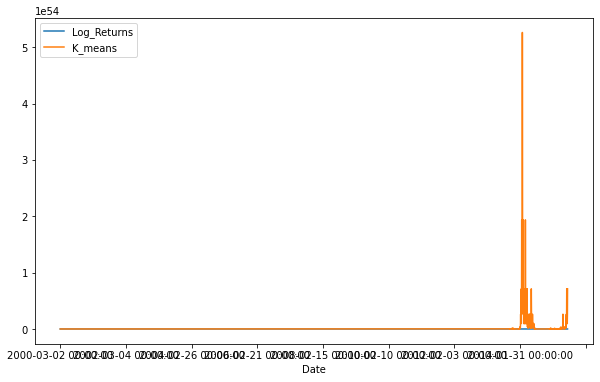

In [115]:
merged_IBM_train[['Log_Returns','K_means']].cumsum().apply(np.exp).plot(figsize=(10,6))